## Task 2 Plan

Station Analysis Plan
* **Accessibility**: Evaluate how well the bike-sharing stations are distributed across the network
  * Metrics: 1) station level average distance to Nearest Neighbours (Geo)
* **Utilisation efficiency**: whether each station has adequate number of bikes
  * Metrics: station level 1) Station Balance: The ratio of incoming to outgoing tripss


## 2.1 Accessibility

In [1]:
import os
import pandas as pd
import numpy as np
import random
import igraph as ig

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import NearestNeighbors

import networkx as nx
import scipy
import scipy.sparse

seed = 2024

In [2]:
stations_geo_df = pd.read_csv("processed_data/stations_geo.csv")
undirectional_edges_df = pd.read_csv("processed_data/total_edge_undirectional.csv")

stations_geo_df = stations_geo_df.dropna()
undirectional_edges_df = undirectional_edges_df.dropna()

In [3]:
def analyze_and_plot(data, edge_data, title_suffix, weight_param = 1, draw_distribution = False):
    X = data[['lat', 'lng']].values

    # Nearest neighbour
    n = 11
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    average_distances = distances[:, 1:].mean(axis=1)
    data['average_nearest_neighbor_distance'] = average_distances

    # Draw distribution
    if draw_distribution is True:
        mean_distance = np.mean(average_distances)
        
        plt.figure(figsize=(10, 6))
        plt.hist(average_distances, bins=50, alpha=0.75, density=True)
        plt.axvline(mean_distance, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f}')
        plt.xlabel('Geographic Distance to Nearest Neighbor')
        plt.ylabel('Density')
        plt.title(f'Distribution of Distance to 10 Nearest Neighbours for Each Station {title_suffix}')
        plt.legend()
        plt.show()

    # Get top 10 percent furthest nodes
    sorted_stations = data.sort_values(by='average_nearest_neighbor_distance', ascending=False)
    top_10_percent_cutoff = int(len(sorted_stations) * 0.1)
    top_10_percent_stations = sorted_stations.head(top_10_percent_cutoff)
    top_10_percent_stations_df = top_10_percent_stations[['station_id', 'average_nearest_neighbor_distance']]

    # Map the nodes based on geo location
    
    nodes = data.set_index('station_id').to_dict('index')
    
    G = nx.Graph()
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)
    
    # Add edges with weights to the graph
    edges = edge_data[['min_station_id', 'max_station_id', 'trip_count']]
    G.add_weighted_edges_from(edges.values)
    
    # Calculate node degrees for sizing (no need to set node attributes)
    degrees = dict(G.degree())
    max_degree = max(degrees.values(), default=1)
    node_sizes = [degrees.get(node, 0) * 200 / max_degree for node in G.nodes()]
    
    degree_threshold = max_degree * 0.9
    
    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, 'weight').values()
    max_weight = max(weights, default=1)
    weights_normalized = [weight * weight_param / max_weight for weight in weights]
    
    # Get positions from node attributes
    pos = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True) if 'lat' in data and 'lng' in data}
    
    # Prepare node colors - default color for most nodes, red for top 10%
    node_colors = ['red' if node in top_10_percent_stations_df['station_id'].to_list() else 'lightgrey' for node in list(G.nodes())]
    red_patch = mpatches.Patch(color='red', label='Top 10% Furthest Stations')
    blue_patch = mpatches.Patch(color='deepskyblue', label='Other Stations')
    
    # Draw the network with improved visual parameters
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.7)
    plt.title(f'Network Graph Based on Geographical Locations {title_suffix}')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right')
    plt.axis('off')
    plt.show()

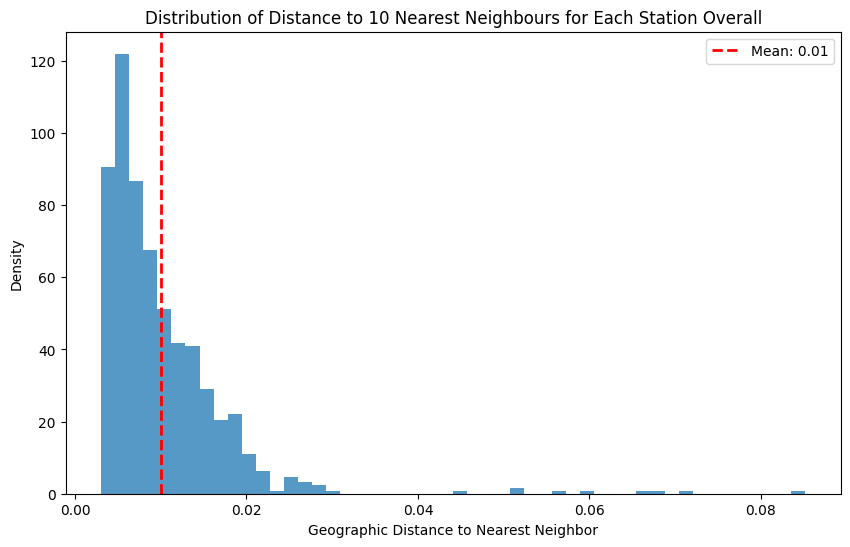

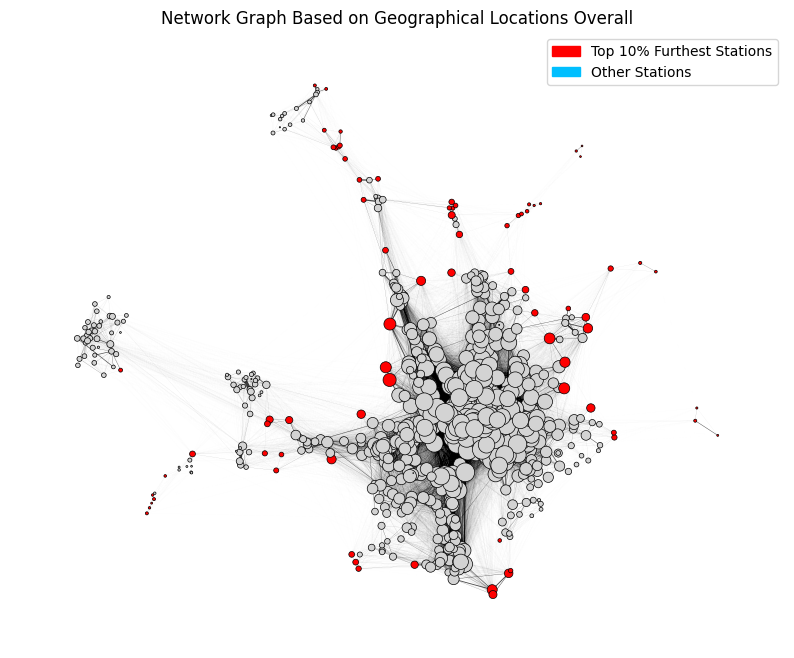

In [4]:
data = stations_geo_df.copy()
edge_data = undirectional_edges_df.copy()
title_suffix = 'Overall'
weight_param = 10
draw_distribution = True

analyze_and_plot(data, edge_data, title_suffix = title_suffix, weight_param = weight_param, draw_distribution = draw_distribution)

## 2.2 Utilisation efficiency

In [5]:
edge_df = pd.read_csv("processed_data/edge_file.csv")
edge_df

Unnamed: 0  year  month  start_station_id  end_station_id  \
0                 0  2023      1           31000.0         31000.0   
1                 1  2023      1           31000.0         31000.0   
2                 2  2023      1           31000.0         31000.0   
3                 3  2023      1           31000.0         31000.0   
4                 4  2023      1           31000.0         31002.0   
...             ...   ...    ...               ...             ...   
1377142     1377142  2024      1           33200.0         31940.0   
1377143     1377143  2024      1           33200.0         31959.0   
1377144     1377144  2024      1           33200.0         33200.0   
1377145     1377145  2024      1           33200.0         33200.0   
1377146     1377146  2024      1           33200.0         33200.0   

         rideable_type member_casual  trip_count  
0         classic_bike        casual           3  
1         classic_bike        member           5  
2          docked_bike        casual           2  
3        electric_bike        casual           1  
4         classic_bike        member           2  
...                ...           ...         ...  
1377142   classic_bike        member           1  
1377143  electric_bike        casual           1  
1377144   classic_bike        casual          10  
1377145   classic_bike        member           1  
1377146  electric_bike        member           1  

[1377147 rows x 8 columns]

In [6]:
# Quarterly data
edge_df['quarter'] = pd.to_datetime(edge_df['month'], format='%m').dt.to_period('Q').dt.quarter
incoming_trips_q = edge_df.groupby(['end_station_id', 'year', 'quarter']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'incoming_trips', 'end_station_id': 'station_id'})
outgoing_trips_q = edge_df.groupby(['start_station_id', 'year', 'quarter']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'outgoing_trips', 'start_station_id': 'station_id'})
merged_trips_q = pd.merge(incoming_trips_q, outgoing_trips_q, on=['station_id', 'year', 'quarter'], how='outer')
merged_trips_q['trip_ratio'] = merged_trips_q['incoming_trips'] / merged_trips_q['outgoing_trips']

# Yearly data
incoming_trips = edge_df.groupby(['end_station_id']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'incoming_trips', 'end_station_id': 'station_id'})
outgoing_trips = edge_df.groupby(['start_station_id']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'outgoing_trips', 'start_station_id': 'station_id'})
merged_trips = pd.merge(incoming_trips, outgoing_trips, on=['station_id'], how='outer')
merged_trips['trip_ratio'] = merged_trips['incoming_trips'] / merged_trips['outgoing_trips']

# Merge with geo
merged_trips_q = pd.merge(merged_trips_q, stations_geo_df, how='inner', on='station_id')
merged_trips = pd.merge(merged_trips, stations_geo_df, how='inner', on='station_id')


In [7]:
merged_trips

station_id  incoming_trips  outgoing_trips  trip_ratio        lat  \
0       30200.0           13654         10285.0    1.327564  38.894273   
1       30201.0           12236         11002.0    1.112161  38.898097   
2       31000.0            4151          4118.0    1.008014  38.858971   
3       31002.0            4693          4690.0    1.000640  38.856425   
4       31003.0            5176          4973.0    1.040820  38.861056   
..          ...             ...             ...         ...        ...   
768     32609.0             692           704.0    0.982955  38.885621   
769     32900.0               1             NaN         NaN  38.964406   
770     32901.0             217           129.0    1.682171  38.963810   
771     32909.0               1             NaN         NaN  38.964459   
772     33200.0            5392          5220.0    1.032950  38.896604   

           lng  
0   -77.024041  
1   -77.023924  
2   -77.053230  
3   -77.049232  
4   -77.049417  
..         ...  
768 -77.166917  
769 -77.010759  
770 -77.010266  
771 -77.010759  
772 -77.039778  

[773 rows x 6 columns]

In [8]:
merged_trips_q

station_id  year  quarter  incoming_trips  outgoing_trips  trip_ratio  \
0        30200.0  2023        1          1411.0          1026.0    1.375244   
1        30200.0  2023        2          3964.0          3131.0    1.266049   
2        30200.0  2023        3          4111.0          3120.0    1.317628   
3        30200.0  2023        4          3546.0          2539.0    1.396613   
4        30200.0  2024        1           622.0           469.0    1.326226   
...          ...   ...      ...             ...             ...         ...   
3723     33200.0  2023        1           431.0           357.0    1.207283   
3724     33200.0  2023        2          1741.0          1733.0    1.004616   
3725     33200.0  2023        3          1750.0          1677.0    1.043530   
3726     33200.0  2023        4          1286.0          1261.0    1.019826   
3727     33200.0  2024        1           184.0           192.0    0.958333   

            lat        lng  
0     38.894273 -77.024041  
1     38.894273 -77.024041  
2     38.894273 -77.024041  
3     38.894273 -77.024041  
4     38.894273 -77.024041  
...         ...        ...  
3723  38.896604 -77.039778  
3724  38.896604 -77.039778  
3725  38.896604 -77.039778  
3726  38.896604 -77.039778  
3727  38.896604 -77.039778  

[3728 rows x 8 columns]

In [9]:
def analyze_and_plot2(data, edge_data, title_suffix, weight_param = weight_param, plot_options={'incoming': True, 'outgoing': True, 'ratio': True}):
    # Histogram
    plt.figure(figsize=(10, 8))
    plot_count = 1

    if plot_options.get('incoming'):
        # Incoming Trips
        mean_income = np.mean(data['incoming_trips'].dropna())
        plt.subplot(2, 2, plot_count)
        plt.hist(data['incoming_trips'].dropna(), bins=30, alpha=0.7, color='red')
        plt.title(f'Total Incoming Trips {title_suffix}')
        plt.xlabel('Number of Incoming Trips')
        plt.ylabel('Frequency')
        plt.axvline(mean_income, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_income:.2f}')
        plt.legend()
        plot_count += 1

    if plot_options.get('outgoing'):
        # Outgoing Trips
        mean_outgoing = np.mean(data['outgoing_trips'].dropna())
        plt.subplot(2, 2, plot_count)
        plt.hist(data['outgoing_trips'].dropna(), bins=30, alpha=0.7, color='deepskyblue')
        plt.title(f'Total Outgoing Trips {title_suffix}')
        plt.xlabel('Number of Outgoing Trips')
        plt.ylabel('Frequency')
        plt.axvline(mean_outgoing, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_outgoing:.2f}')
        plt.legend()
        plot_count += 1

    if plot_options.get('ratio'):
        # Trip Ratio
        mean_ratio = np.mean(data['trip_ratio'].dropna())
        if plot_count <= 2:
            plt.subplot(2, 2, plot_count)
        else:
            plt.subplot(2, 1, 2)
        plt.hist(data['trip_ratio'].dropna(), bins=30, alpha=0.7, color='green')
        plt.title(f'Trip Ratio {title_suffix}')
        plt.xlabel('Trip Ratio')
        plt.ylabel('Frequency')
        plt.axvline(mean_ratio, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_ratio:.2f}')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate the top 10 and bottom 10 percent trip ratio
    sorted_trips_des = data.dropna().sort_values(by='trip_ratio', ascending=False)
    sorted_trips_asc = data.dropna().sort_values(by='trip_ratio', ascending=True)

    top_10_percent_cutoff = int(len(sorted_trips_des) * 0.1)
    bottom_10_percent_cutoff = int(len(sorted_trips_asc) * 0.1)
    
    top_10_percent_df = sorted_trips_des.head(top_10_percent_cutoff)
    bottom_10_percent_df = sorted_trips_asc.head(bottom_10_percent_cutoff)

    # Draw on map
    nodes = data.set_index('station_id').to_dict('index')
    G = nx.Graph()
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)
    
    # Add edges with weights to the graph
    edges = edge_data[['min_station_id', 'max_station_id', 'trip_count']]
    G.add_weighted_edges_from(edges.values)
    
    # Calculate node degrees for sizing (no need to set node attributes)
    degrees = dict(G.degree())
    max_degree = max(degrees.values(), default=1)
    node_sizes = [degrees.get(node, 0) * 200 / max_degree for node in G.nodes()]
    
    degree_threshold = max_degree * 0.9
    
    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, 'weight').values()
    max_weight = max(weights, default=1)
    weights_normalized = [weight * 10 / max_weight for weight in weights]
    
    # Get positions from node attributes
    pos = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True)}
    
    # Prepare node colors - default color for most nodes, red for top 10%
    node_colors = ['red' if node in top_10_percent_df['station_id'].to_list() else 'deepskyblue' if node in bottom_10_percent_df['station_id'].to_list() else 'lightgrey' for node in list(G.nodes())]
    red_patch = mpatches.Patch(color='red', label='Top 10% Most Imbalanced Stations in Incoming Bikes')
    blue_patch = mpatches.Patch(color='deepskyblue', label='Top 10% Most Imbalanced Stations in Outgoing Bikes')
    grey_patch = mpatches.Patch(color='lightgrey', label='Other Stations')
    
    # Draw the network with improved visual parameters
    plt.figure(figsize=(15, 12))
    ax = plt.gca()
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.7)
    plt.title(f'Network Graph Based on Geographical Locations {title_suffix}')
    plt.legend(handles=[red_patch, blue_patch, grey_patch], loc='upper right')
    plt.axis('off')
    plt.show()

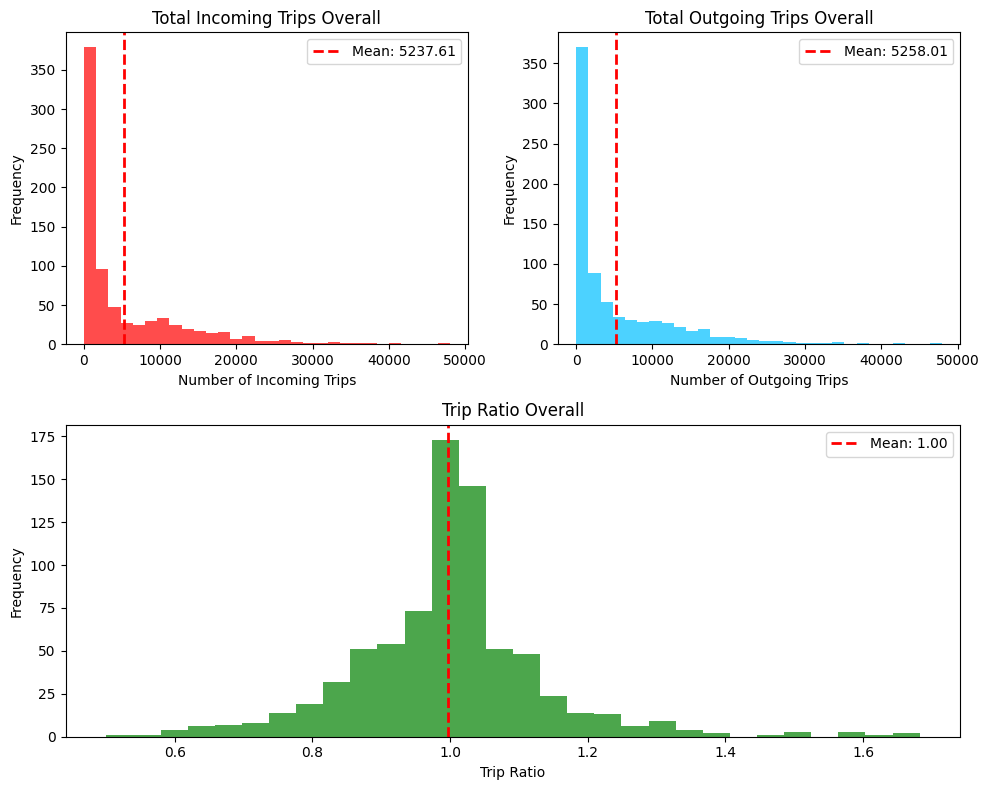

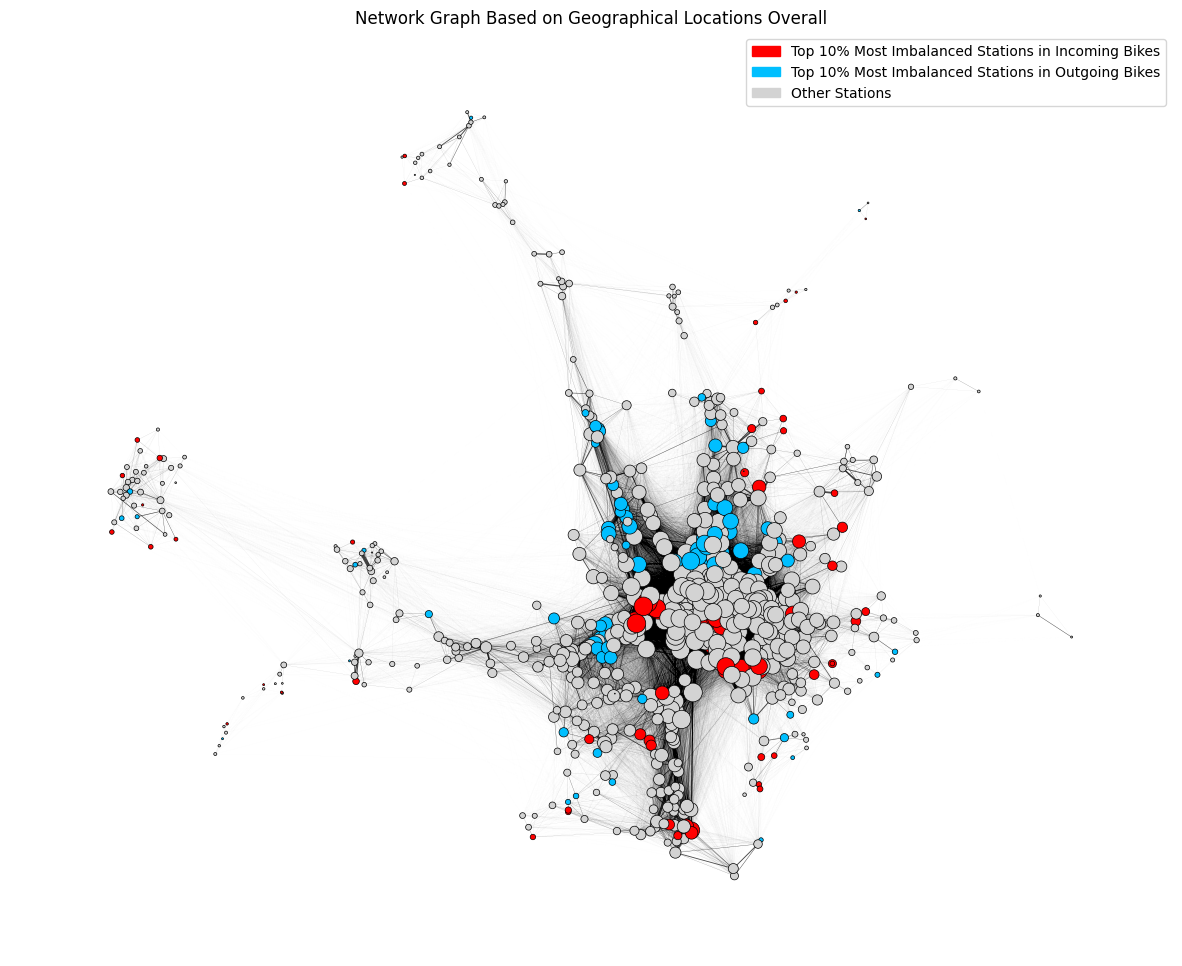

In [10]:
data = merged_trips.copy()
edge_data = undirectional_edges_df.copy()
title_suffix = 'Overall'
weight_param = 10

analyze_and_plot2(data, edge_data, title_suffix = title_suffix, weight_param = weight_param)

## 2.3 Quarterly Analysis

In [11]:
# Quarterly directional edge file
edge_file = pd.read_csv("processed_data/edge_file.csv")
edge_file = edge_file.dropna()
edge_file['quarter'] = pd.to_datetime(edge_file['month'], format='%m').dt.to_period('Q').dt.quarter

edge_file = edge_file.groupby(['year', 'quarter', 'start_station_id', 'end_station_id'])['trip_count'].sum().reset_index()

# Quarterly undirectional edge file for geo plot
edges_df_total = edge_file[['year', 'quarter', 'start_station_id', 'end_station_id', 'trip_count']].copy()
edges_df_total[['start_station_id', 'end_station_id']] = edges_df_total[['start_station_id', 'end_station_id']].astype(int)

# Sort the station IDs within each row to handle them as undirected edges
edges_df_total['min_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].min(axis=1)
edges_df_total['max_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].max(axis=1)

# Group by the sorted station IDs and sum the trip counts
undirectional_edge_file = edges_df_total.groupby(['year', 'quarter', 'min_station_id', 'max_station_id'])['trip_count'].sum().reset_index()

# Remove nodes where min = max
undirectional_edge_file = undirectional_edge_file[undirectional_edge_file.min_station_id != undirectional_edge_file.max_station_id]

In [12]:
undirectional_edge_file

year  quarter  min_station_id  max_station_id  trip_count
1       2023        1           30200           30201          43
2       2023        1           30200           31002           1
3       2023        1           30200           31007           3
4       2023        1           30200           31013           1
5       2023        1           30200           31016           1
...      ...      ...             ...             ...         ...
251057  2024        1           32606           32608           2
251058  2024        1           32606           32609           1
251060  2024        1           32607           32608           7
251061  2024        1           32607           32609           3
251062  2024        1           32608           32609           2

[247470 rows x 5 columns]

In [13]:
# Quarterly directional node file
station_list = [undirectional_edge_file[['year', 'quarter', 'min_station_id']].rename(columns={'min_station_id':'station_id'}), 
                undirectional_edge_file[['year', 'quarter', 'max_station_id']].rename(columns={'max_station_id':'station_id'})]

station_list = pd.concat(station_list, ignore_index=True).drop_duplicates(subset=['year', 'quarter', 'station_id'])
station_list = pd.merge(station_list, stations_geo_df, how='inner', on='station_id')

station_list

year  quarter  station_id        lat        lng
0     2023        1       30200  38.894273 -77.024041
1     2023        2       30200  38.894273 -77.024041
2     2023        3       30200  38.894273 -77.024041
3     2023        4       30200  38.894273 -77.024041
4     2024        1       30200  38.894273 -77.024041
...    ...      ...         ...        ...        ...
3721  2024        1       32083  39.051022 -77.115438
3722  2023        4       32909  38.964459 -77.010759
3723  2023        4       31980  38.864519 -77.083636
3724  2023        4       32283  38.844249 -77.305336
3725  2024        1       32283  38.844249 -77.305336

[3726 rows x 5 columns]

In [14]:
stations_geo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 773 entries, 0 to 773
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  773 non-null    float64
 1   lat         773 non-null    float64
 2   lng         773 non-null    float64
dtypes: float64(3)
memory usage: 24.2 KB


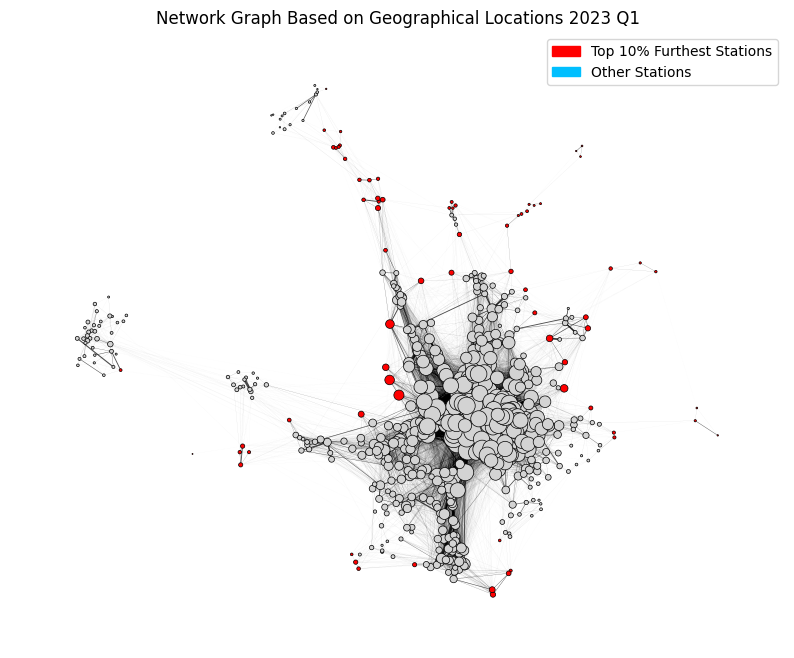

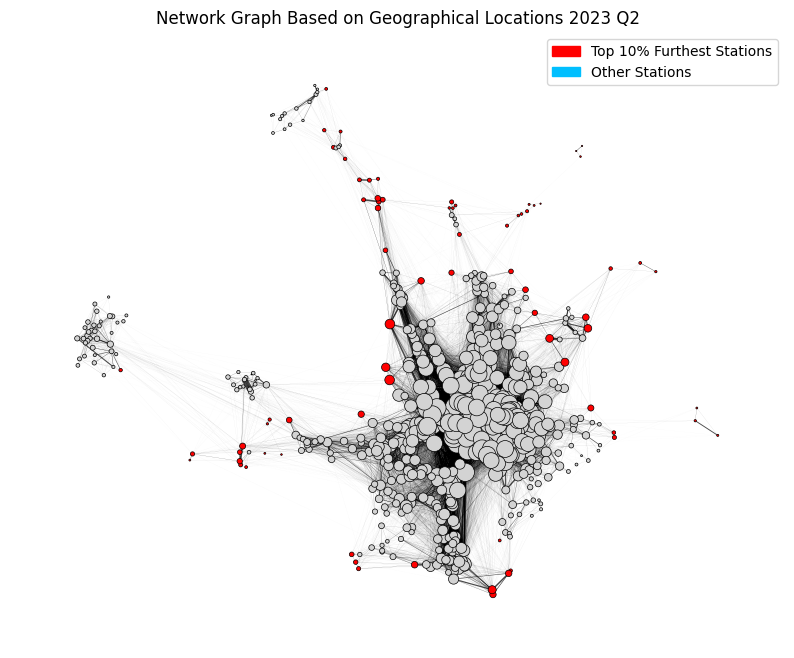

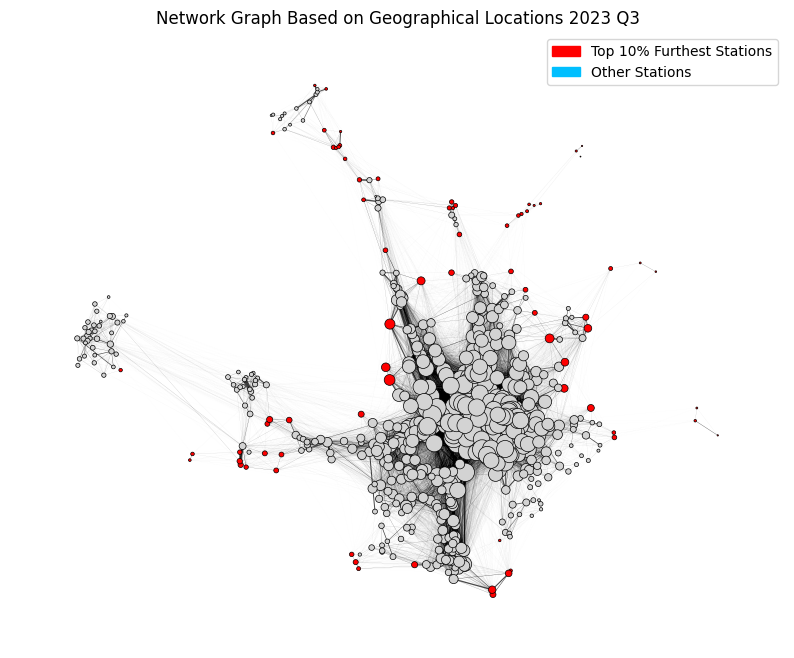

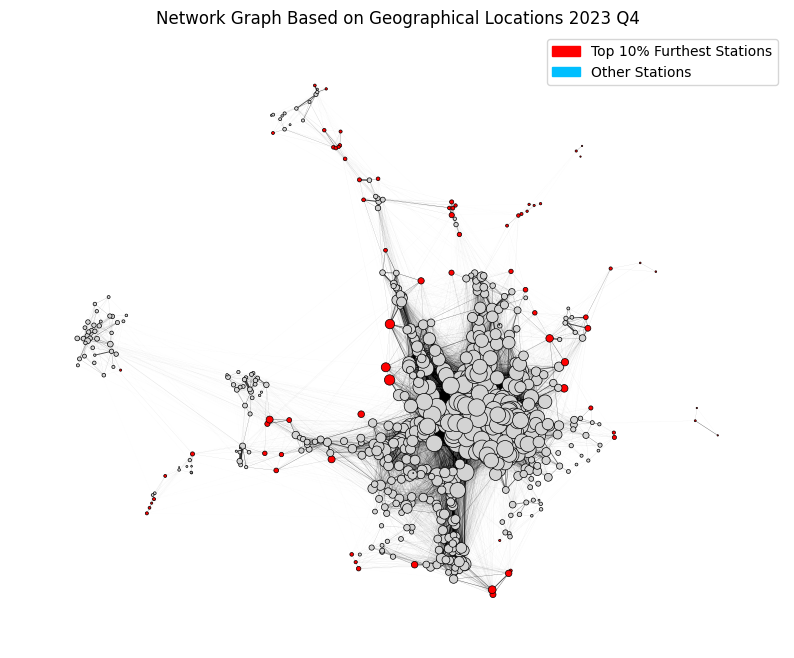

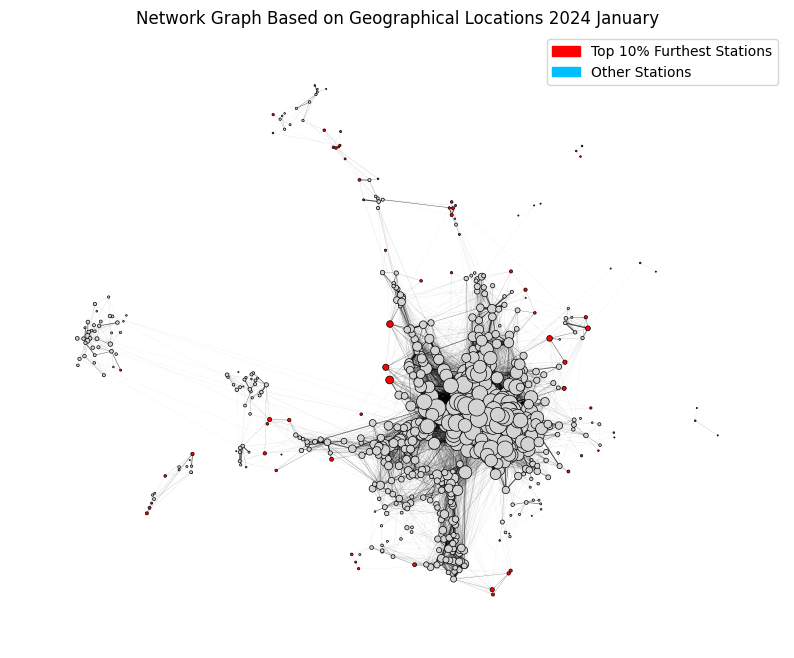

In [15]:
timeframes = [
    ("2023 Q1", 2023, 1),
    ("2023 Q2", 2023, 2),
    ("2023 Q3", 2023, 3),
    ("2023 Q4", 2023, 4),
    ("2024 January", 2024, 1),
]

for title, year, quarter in timeframes:
    data = station_list.copy()
    data = data[(data['year'] == year) & (data['quarter'] == quarter)]
    data = data [['station_id', 'lat', 'lng']]
    # print(data)
    
    edge_data = undirectional_edge_file.copy()
    edge_data = edge_data[(edge_data['year'] == year) & (edge_data['quarter'] == quarter)]
    edge_data = edge_data[['min_station_id', 'max_station_id', 'trip_count']]
    # print(edge_data)
    
    title_suffix = title
    weight_param = 10
    draw_distribution = False

    analyze_and_plot(data, edge_data, title_suffix = title_suffix, weight_param = weight_param, draw_distribution = draw_distribution)

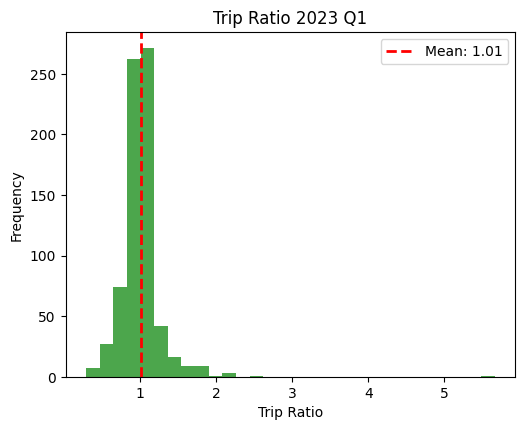

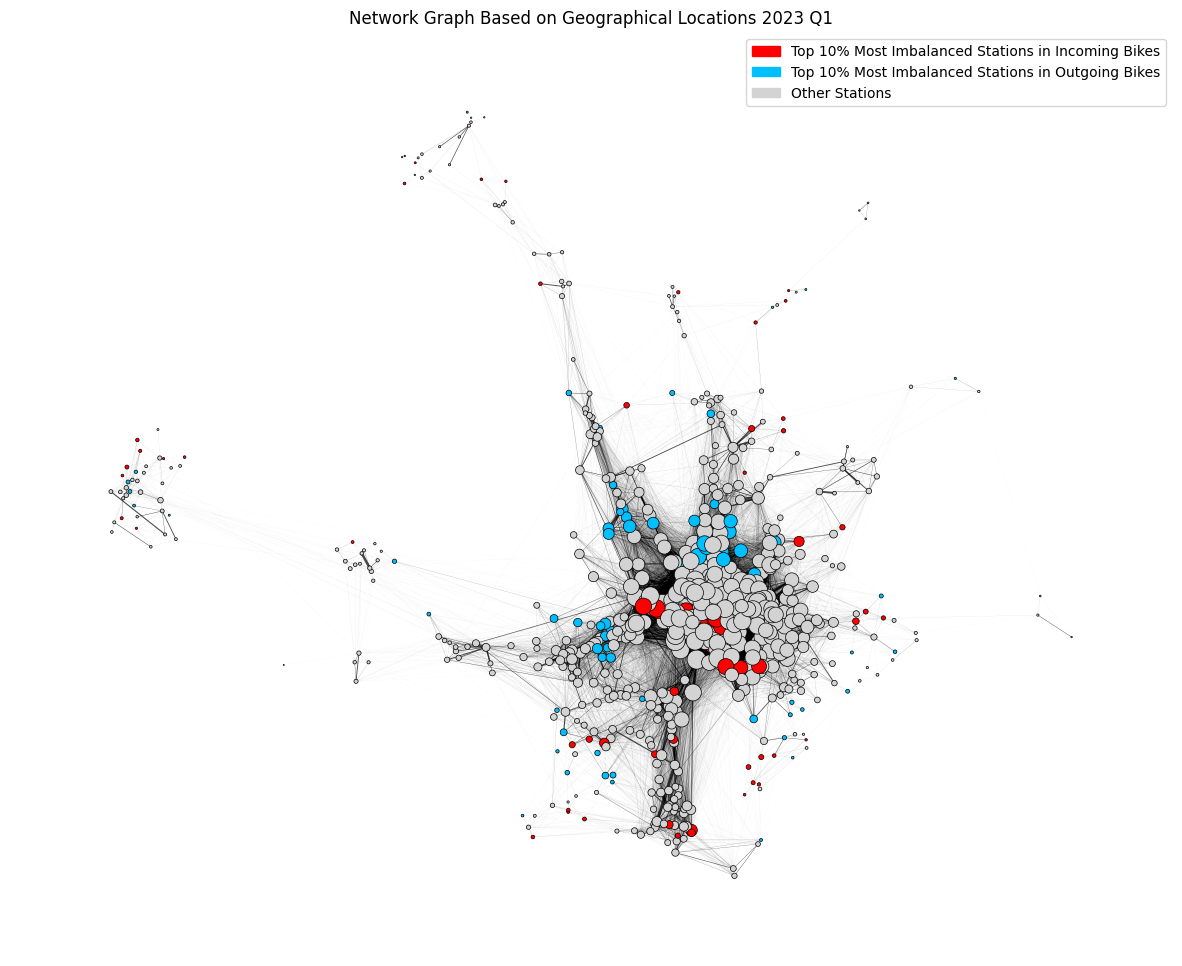

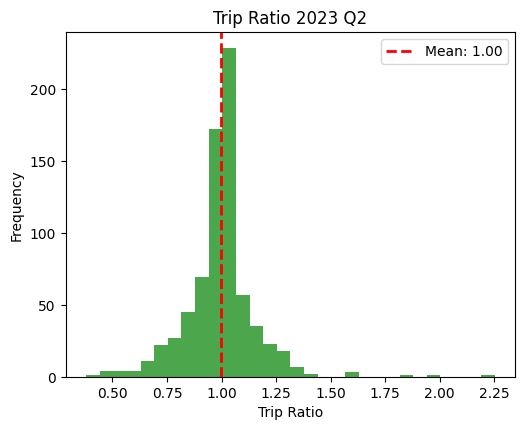

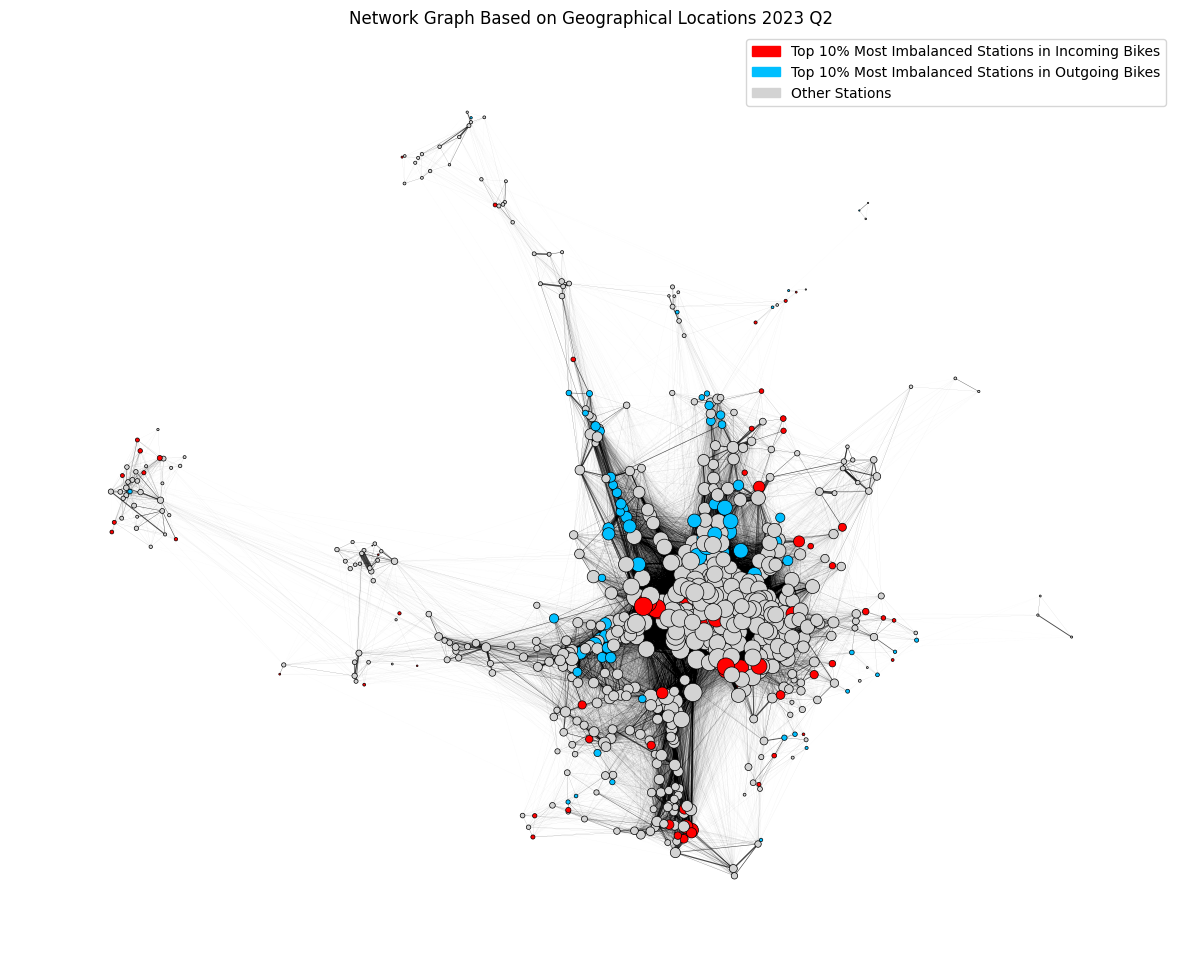

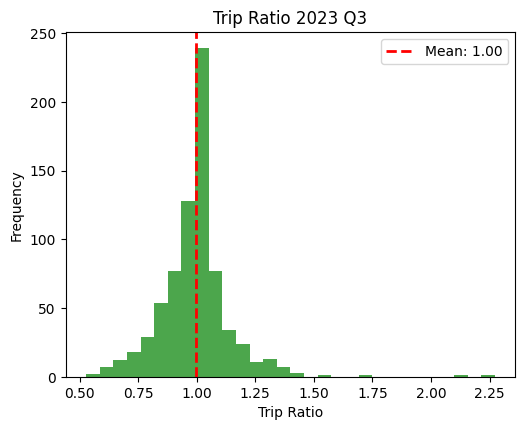

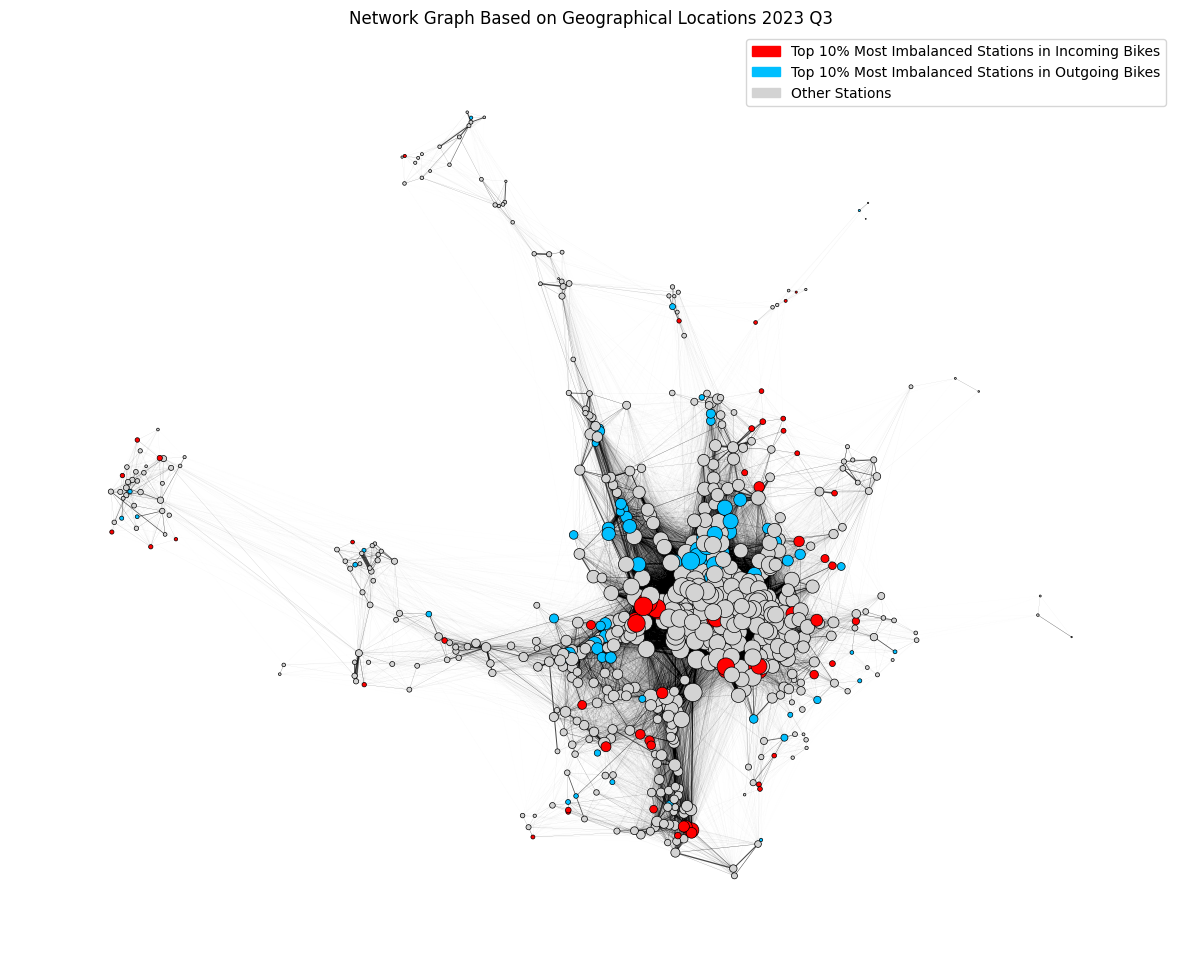

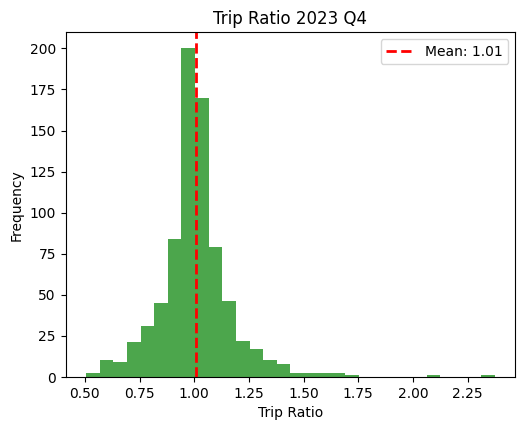

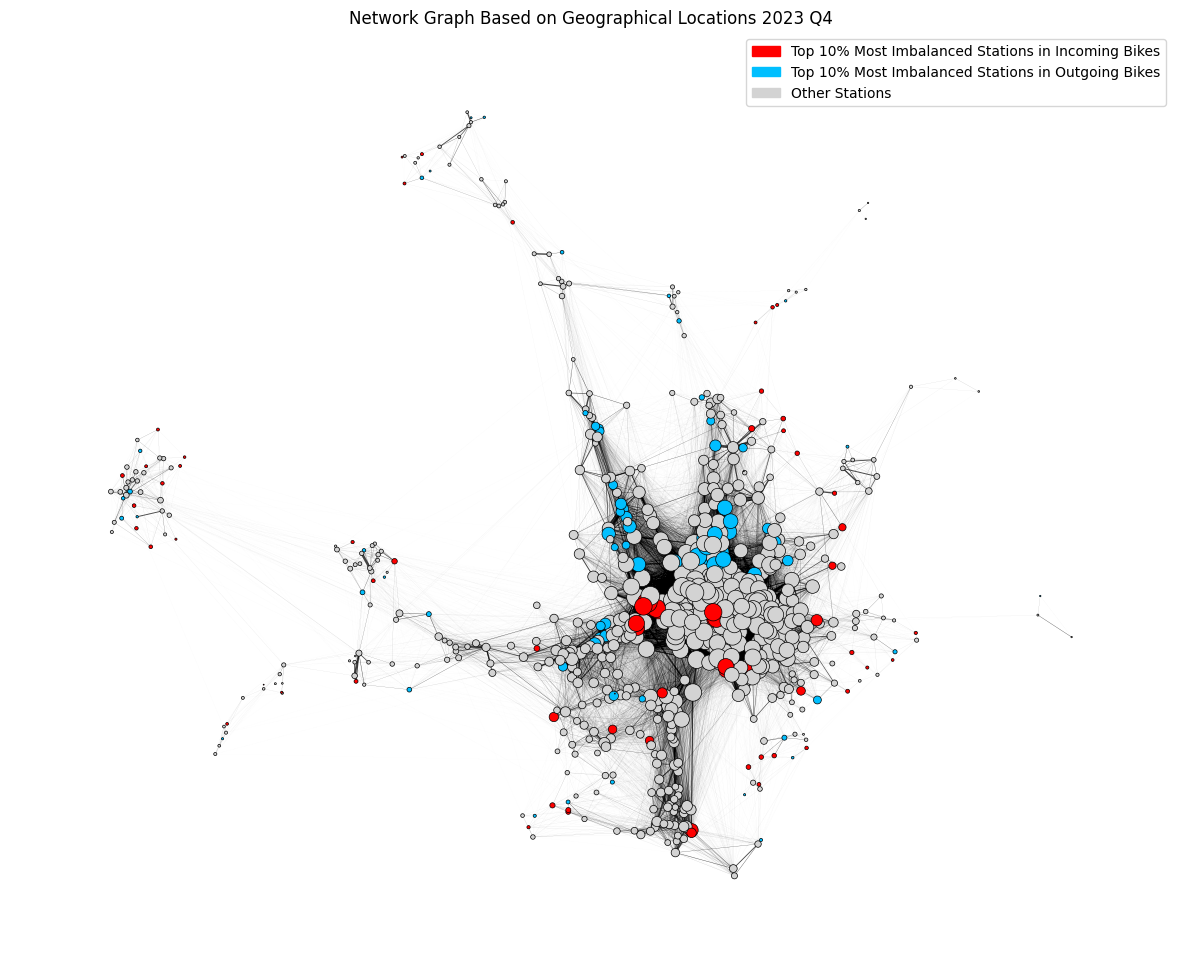

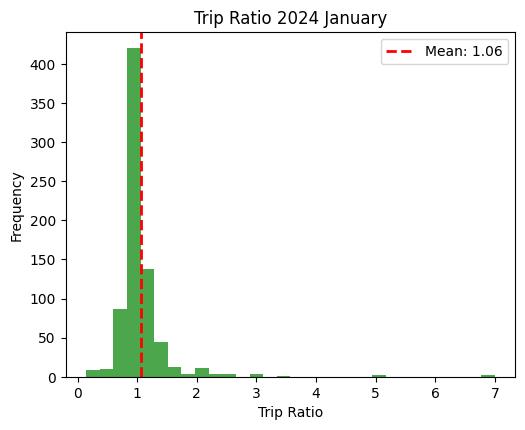

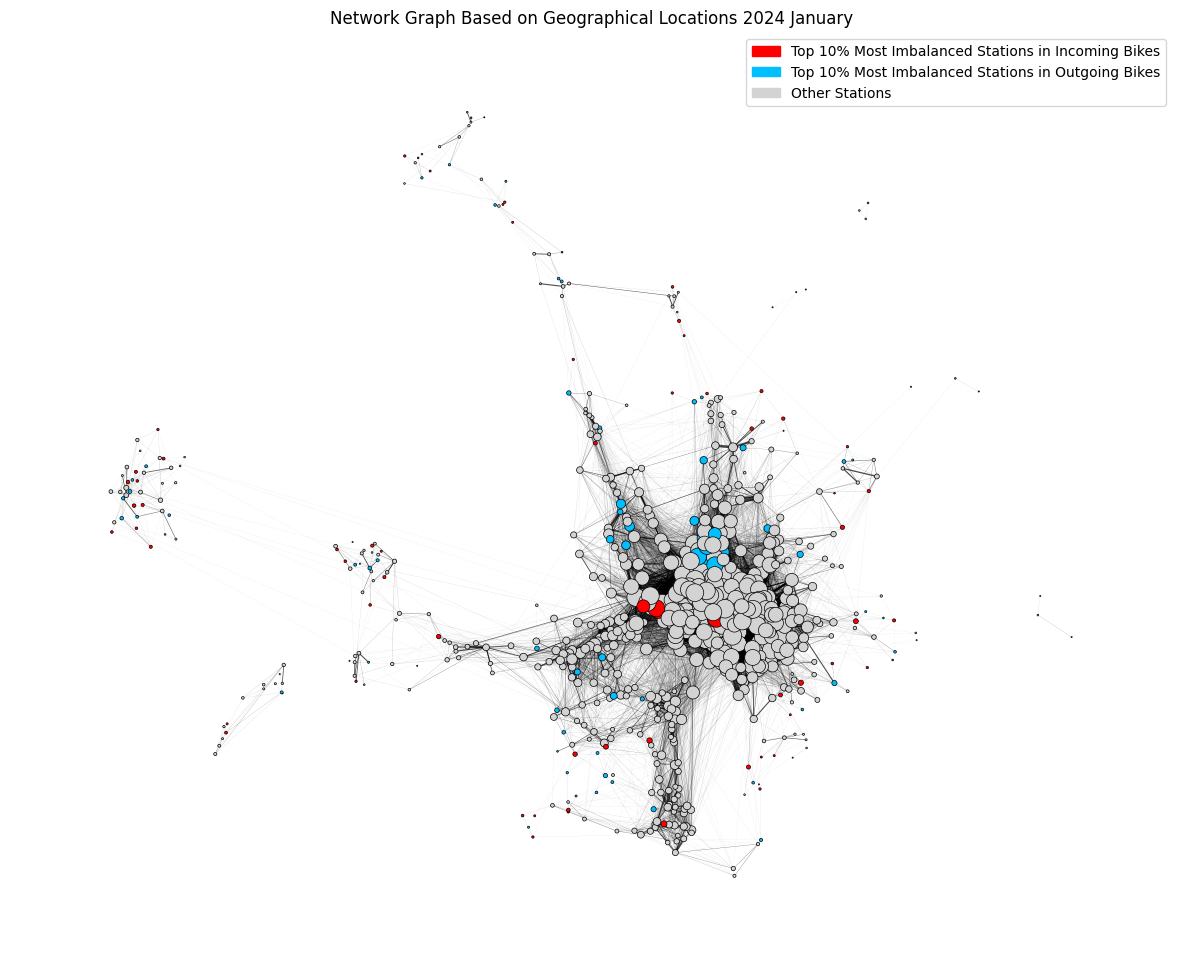

In [16]:
# Quarterly Flow Balance
for title, year, quarter in timeframes:
    data = merged_trips_q.copy()
    data = data[(data['year'] == year) & (data['quarter'] == quarter)]
    # print(data)
    
    edge_data = undirectional_edge_file.copy()
    edge_data = edge_data[(edge_data['year'] == year) & (edge_data['quarter'] == quarter)]
    # print(edge_data)
    
    title_suffix = title
    weight_param = 1
    plot_options={'incoming': False, 'outgoing': False, 'ratio': True}

    analyze_and_plot2(data, edge_data, title_suffix = title_suffix, weight_param = weight_param, plot_options = plot_options)

## 2.4 Bike type analysis

In [19]:
edge_df

Unnamed: 0  year  month  start_station_id  end_station_id  \
0                 0  2023      1           31000.0         31000.0   
1                 1  2023      1           31000.0         31000.0   
2                 2  2023      1           31000.0         31000.0   
3                 3  2023      1           31000.0         31000.0   
4                 4  2023      1           31000.0         31002.0   
...             ...   ...    ...               ...             ...   
1377142     1377142  2024      1           33200.0         31940.0   
1377143     1377143  2024      1           33200.0         31959.0   
1377144     1377144  2024      1           33200.0         33200.0   
1377145     1377145  2024      1           33200.0         33200.0   
1377146     1377146  2024      1           33200.0         33200.0   

         rideable_type member_casual  trip_count  quarter  
0         classic_bike        casual           3        1  
1         classic_bike        member           5        1  
2          docked_bike        casual           2        1  
3        electric_bike        casual           1        1  
4         classic_bike        member           2        1  
...                ...           ...         ...      ...  
1377142   classic_bike        member           1        1  
1377143  electric_bike        casual           1        1  
1377144   classic_bike        casual          10        1  
1377145   classic_bike        member           1        1  
1377146  electric_bike        member           1        1  

[1377147 rows x 9 columns]

In [20]:
# Bike type data
incoming_trips = edge_df.groupby(['end_station_id', 'rideable_type']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'incoming_trips', 'end_station_id': 'station_id'})
outgoing_trips = edge_df.groupby(['start_station_id', 'rideable_type']).agg({'trip_count': 'sum'}).reset_index().rename(columns={'trip_count': 'outgoing_trips', 'start_station_id': 'station_id'})
merged_trips = pd.merge(incoming_trips, outgoing_trips, on=['station_id', 'rideable_type'], how='outer')
merged_trips['trip_ratio'] = merged_trips['incoming_trips'] / merged_trips['outgoing_trips']

# Merge with geo
merged_trips = pd.merge(merged_trips, stations_geo_df, how='inner', on='station_id')
merged_trips

station_id  rideable_type  incoming_trips  outgoing_trips  trip_ratio  \
0        30200.0   classic_bike         10845.0          7678.0    1.412477   
1        30200.0    docked_bike           706.0           535.0    1.319626   
2        30200.0  electric_bike          2103.0          2072.0    1.014961   
3        30201.0   classic_bike          9396.0          8107.0    1.158998   
4        30201.0    docked_bike           312.0           388.0    0.804124   
...          ...            ...             ...             ...         ...   
2262     32901.0  electric_bike            55.0            11.0    5.000000   
2263     32909.0   classic_bike             1.0             NaN         NaN   
2264     33200.0   classic_bike          4042.0          3927.0    1.029284   
2265     33200.0    docked_bike           610.0           497.0    1.227364   
2266     33200.0  electric_bike           740.0           796.0    0.929648   

            lat        lng  
0     38.894273 -77.024041  
1     38.894273 -77.024041  
2     38.894273 -77.024041  
3     38.898097 -77.023924  
4     38.898097 -77.023924  
...         ...        ...  
2262  38.963810 -77.010266  
2263  38.964459 -77.010759  
2264  38.896604 -77.039778  
2265  38.896604 -77.039778  
2266  38.896604 -77.039778  

[2267 rows x 7 columns]

In [26]:
# Construct undirectional network datafile
edge_file = pd.read_csv("processed_data/edge_file.csv")
edge_file = edge_file.dropna()

edge_file_type = edge_file[['start_station_id', 'end_station_id', 'rideable_type','trip_count']].copy()

# Sort the station IDs within each row to handle them as undirected edges
edge_file_type['min_station_id'] = edge_file_type[['start_station_id', 'end_station_id']].min(axis=1)
edge_file_type['max_station_id'] = edge_file_type[['start_station_id', 'end_station_id']].max(axis=1)

# Group by the sorted station IDs and sum the trip counts
undirectional_edges_type = edge_file_type.groupby(['min_station_id', 'max_station_id', 'rideable_type'])['trip_count'].sum().reset_index()

# Remove nodes where min = max
undirectional_edges_type = undirectional_edges_type[undirectional_edges_type.min_station_id != undirectional_edges_type.max_station_id]
undirectional_edges_type

min_station_id  max_station_id  rideable_type  trip_count
3              30200.0         30201.0   classic_bike         279
4              30200.0         30201.0    docked_bike          14
5              30200.0         30201.0  electric_bike          41
6              30200.0         31002.0   classic_bike           4
7              30200.0         31002.0  electric_bike           5
...                ...             ...            ...         ...
153953         32607.0         32609.0    docked_bike           2
153954         32607.0         32609.0  electric_bike           8
153958         32608.0         32609.0   classic_bike          52
153959         32608.0         32609.0  electric_bike          28
153965         32901.0         33200.0    docked_bike           1

[151798 rows x 4 columns]

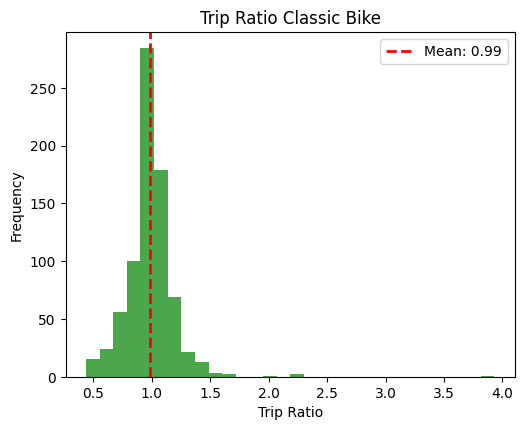

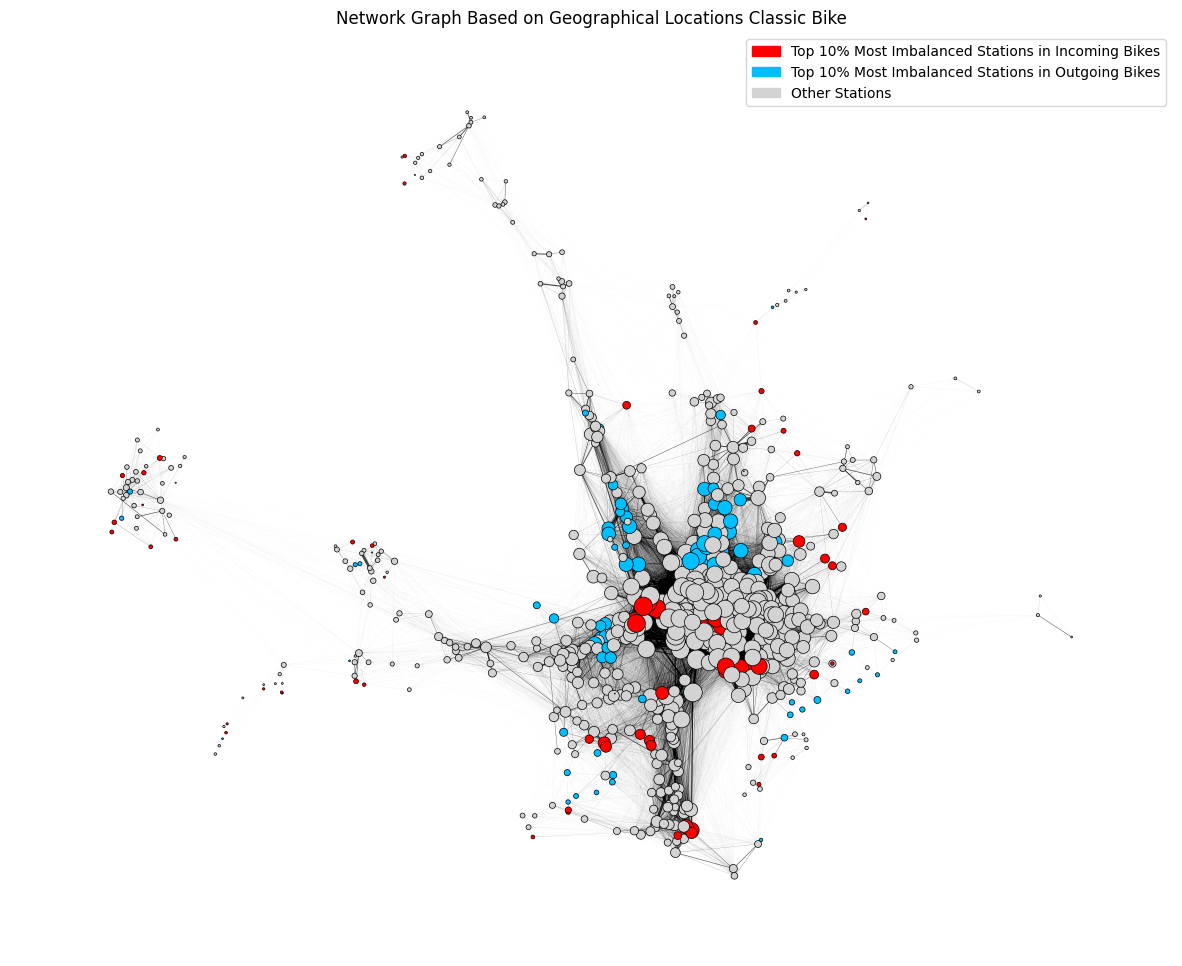

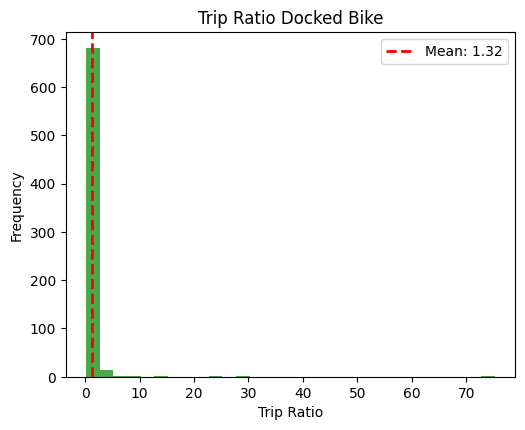

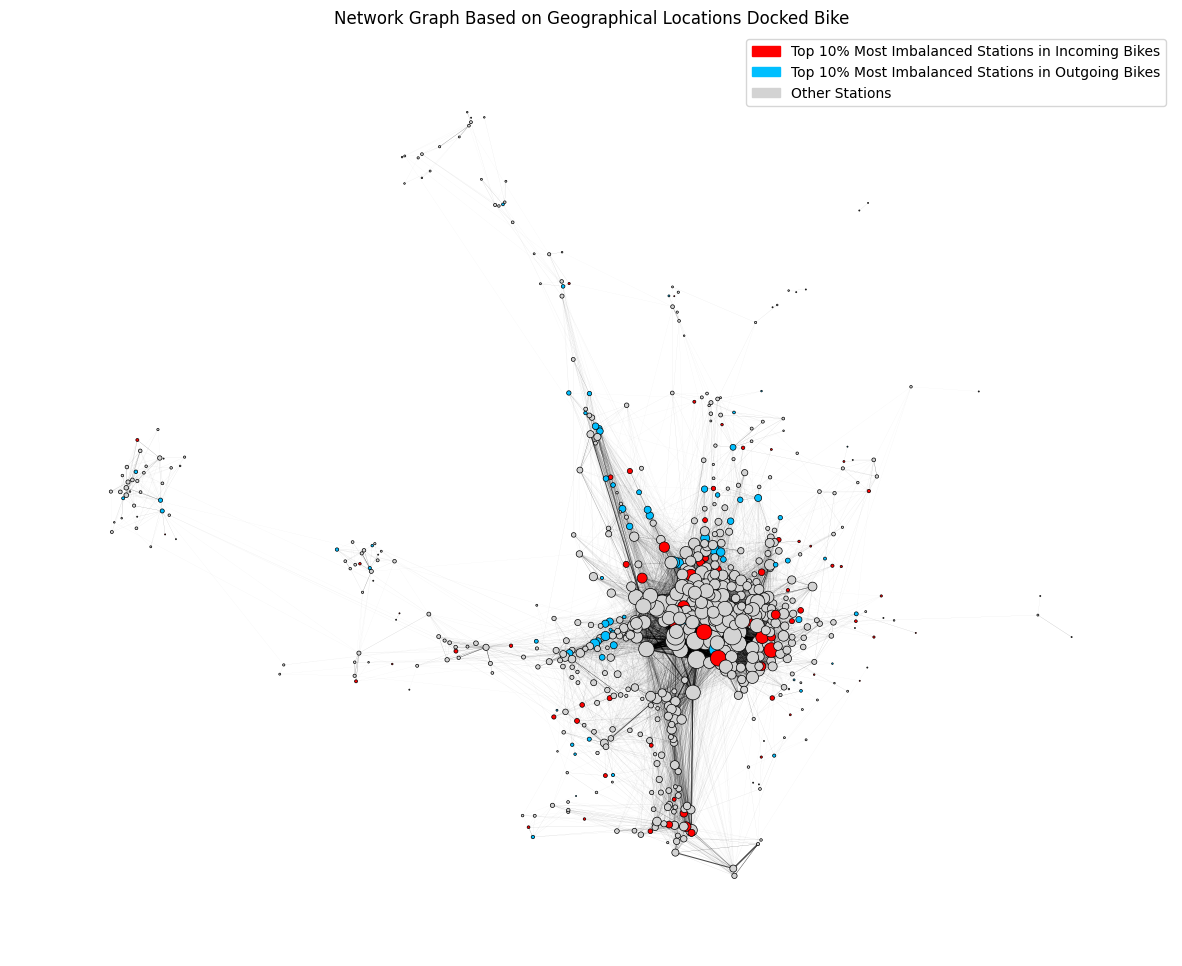

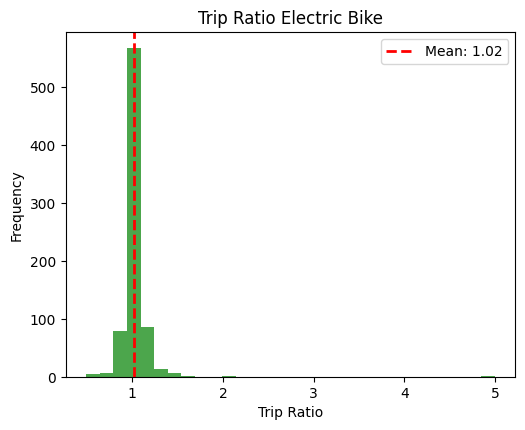

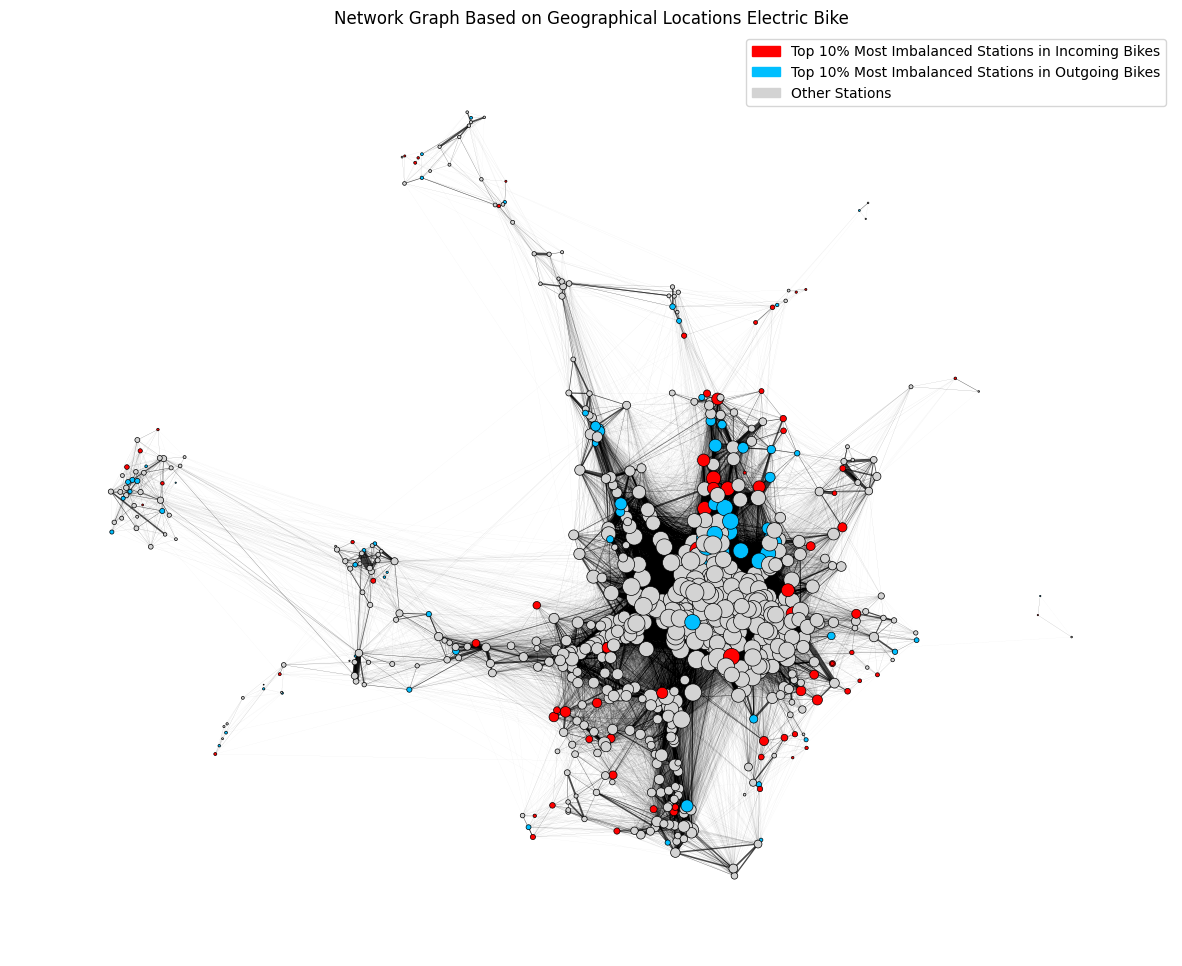

In [28]:
# Quarterly Flow Balance
bikeframes = [
    ("Classic Bike", 'classic_bike'),
    ("Docked Bike", 'docked_bike'),
    ("Electric Bike", 'electric_bike')
]

# Quarterly Flow Balance
for title, bike_type in bikeframes:
    data = merged_trips.copy()
    data = data[data['rideable_type'] == bike_type]
    # print(data)
    
    edge_data = undirectional_edges_type.copy()
    edge_data = edge_data[edge_data['rideable_type'] == bike_type]
    # print(edge_data)
    
    title_suffix = title
    weight_param = 1
    plot_options={'incoming': False, 'outgoing': False, 'ratio': True}

    analyze_and_plot2(data, edge_data, title_suffix = title_suffix, weight_param = weight_param, plot_options = plot_options)

## 2.5 Time interval analysis